In [4]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
from symai import Symbol

In [204]:
plt.rcParams['text.usetex'] = True

In [104]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel="rbf"):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)

    return torch.mean(XX + YY - 2. * XY)
    # return XX, YY, -2. * XY

In [129]:
def rbf_kernel(v, o, bandwidth=[10, 15, 20, 50]):
    d = torch.sum((v - o)**2, axis=0)
    
    if bandwidth is not None:
        value = 0
        for a in bandwidth:
            gamma = 1.0 / (2 * a) 
            value += torch.exp(-gamma * d)
        return value
        
    gamma = 1
    return torch.exp(-gamma * d)

In [145]:
m = 20 # sample size
x_mean = torch.zeros(2)+1
y_mean = torch.zeros(2)
x_cov = 2*torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
y_cov = 3*torch.eye(2) - 1

px = MultivariateNormal(x_mean, x_cov)
qy = MultivariateNormal(y_mean, y_cov)
x = px.sample([m]).to(device)
y = qy.sample([m]).to(device)

In [146]:
xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
rx = (xx.diag().unsqueeze(0).expand_as(xx))
ry = (yy.diag().unsqueeze(0).expand_as(yy))

In [147]:
dxx = rx.t() + rx - 2. * xx # Used for A in (1)
dyy = ry.t() + ry - 2. * yy # Used for B in (1)
dxy = rx.t() + ry - 2. * zz # Used for C in (1)

In [241]:
def normalize_score(score, base_score, rand_score, eps=1e-8):
    base_score = base_score.value if isinstance(base_score, Symbol) else base_score
    rand_score = rand_score.value if isinstance(rand_score, Symbol) else rand_score
    score      = score.value if isinstance(score, Symbol) else score
    # Ensure that the baseline score is always higher or equal to the random score
    z       = 1.0 / np.maximum(base_score - rand_score, eps)
    z_rand  = rand_score * z
    score   = score * z - z_rand
    # Do not allow negative scores
    res     = np.clip(score, 0.0, 1.0)
    # return Symbol(res)
    return res

In [280]:
D = 768
N = 1
x = torch.from_numpy(np.random.normal(50, 25, size=(N, D))) # if 50 -> 0 and 25 -> 2, score is good
y = torch.from_numpy(np.random.normal(0, 2, size=(N, D)))
# we mess with the spread! it's still gaussian, but lower spread; multiply by sqrt(sample_size) (eg. sqrt(N*1000)) to rescale back
trajectories = torch.from_numpy(np.random.normal(0, 2, size=(N*1000, D))).mean(0, keepdim=True)
random       = torch.from_numpy(np.random.uniform(0, 100, (N*10, D))).mean(0, keepdim=True)

In [281]:
f"Just kernel: {rbf_kernel(x, y).mean()}; MDD: {MMD(x.T, y.T)}"

'Just kernel: 0.10722062200508893; MDD: 3.6268985271453857'

In [289]:
rand_score_ker = rbf_kernel(y, random).mean()
base_score_ker = rbf_kernel(y, trajectories).mean()
rand_score_mdd = MMD(y.T, random.T)
base_score_mdd = MMD(y.T, trajectories.T)

In [291]:
print(f"Kernel:\nBase score (not rescaled): {base_score_ker}; Random score: {rand_score_ker}") # higher better (similarity)
print() 
print(f"MDD:\nBase score (not rescaled): {base_score_mdd}; Random score: {rand_score_mdd}")    # lower better  (distance)

Kernel:
Base score (not rescaled): 3.6022879207840552; Random score: 0.0001259149197928372

MDD:
Base score (not rescaled): 0.11352632939815521; Random score: 4.60649299621582


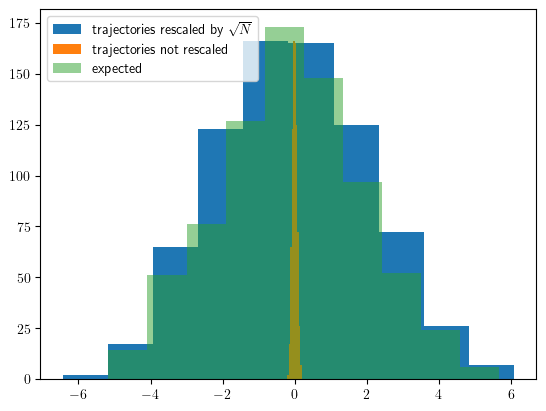

In [284]:
_, ax = plt.subplots(1, 1)
ax.hist(trajectories.squeeze().numpy() * (N*1000)**0.5, label=r"trajectories rescaled by $\sqrt{N}$")
ax.hist(trajectories.squeeze().numpy(), label="trajectories not rescaled")
ax.hist(y.squeeze().numpy(), label="expected", alpha=.5)
# ax.hist(x.squeeze().numpy(), label="predicted", alpha=.5) # Uncomment to also see the predicted dist
plt.legend()

In [292]:
rand_score_ker = rbf_kernel(y, random).mean()
base_score_ker = rbf_kernel(y, trajectories * (N*1000)**0.5).mean()
rand_score_mdd = MMD(y.T, random.T)
base_score_mdd = MMD(y.T, (trajectories * (N*1000)**0.5).T)

In [293]:
print(f"Kernel:\nBase score (properly rescaled): {base_score_ker}; Random score: {rand_score_ker}") # higher better (similarity)
print() 
print(f"MDD:\nBase score (properly rescaled): {base_score_mdd}; Random score: {rand_score_mdd}")    # lower better  (distance)

# So there's no difference for scoring if we rescale or not… Unless it seems insignificant. It's because of the high dimensionality?

Kernel:
Base score (properly rescaled): 3.283468310067862; Random score: 0.0001259149197928372

MDD:
Base score (properly rescaled): 0.0007662826683372259; Random score: 4.60649299621582


In [298]:
pred_ker = rbf_kernel(y, x).mean()
pred_mdd = MMD(y.T, x.T)

In [300]:
print(f"Kernel (normalized score): {normalize_score(pred_ker, base_score_ker, rand_score_ker)}")
print()
print(f"MDD (normalized score): {normalize_score(pred_mdd, base_score_mdd, rand_score_mdd)}") # why zero? we don't need to rescale this I suppose!

Kernel (normalized score): 0.03261758726216138

MDD (normalized score): 0.0


# Let's see how metrics change as distributions change

In [305]:
D = 768 # Embedding dim
N = 1   # Number of samples for prediction and ground truth; mimics embedding a string and returning (1, D)

mdd_scores = []
ker_scores = []
# Let's vary the mean first…
for mu in range(100):
    x = torch.from_numpy(np.random.normal(mu, 1, size=(N, D)))
    y = torch.from_numpy(np.random.normal(0, 1, size=(N, D))) # standard normal
    trajectories = torch.from_numpy(np.random.normal(0, 1, size=(N*1000, D))).mean(0, keepdim=True) # Sample 1000 trajectories
    random       = torch.from_numpy(np.random.uniform(0, 100, (N*10, D))).mean(0, keepdim=True)     # Sample 10 random sequences

    rand_score_ker = rbf_kernel(y, random).mean()
    base_score_ker = rbf_kernel(y, trajectories).mean()
    rand_score_mdd = MMD(y.T, random.T)
    base_score_mdd = MMD(y.T, trajectories.T)

    pred_ker = rbf_kernel(y, x).mean()
    pred_ker = normalize_score(pred_ker, base_score_ker, rand_score_ker)
    pred_mdd = MMD(y.T, x.T)  

    mdd_scores.append(pred_mdd)
    ker_scores.append(pred_ker)

In [313]:
mdd_scores = np.array(mdd_scores)
ker_scores = np.array(ker_scores)

In [333]:
plt.style.use("ggplot")

Text(0.5, 1.0, 'Divergence testing; $N(\\mu, \\sigma^2)$ as $\\mu$ goes from $0 \\rightarrow \\infty$')

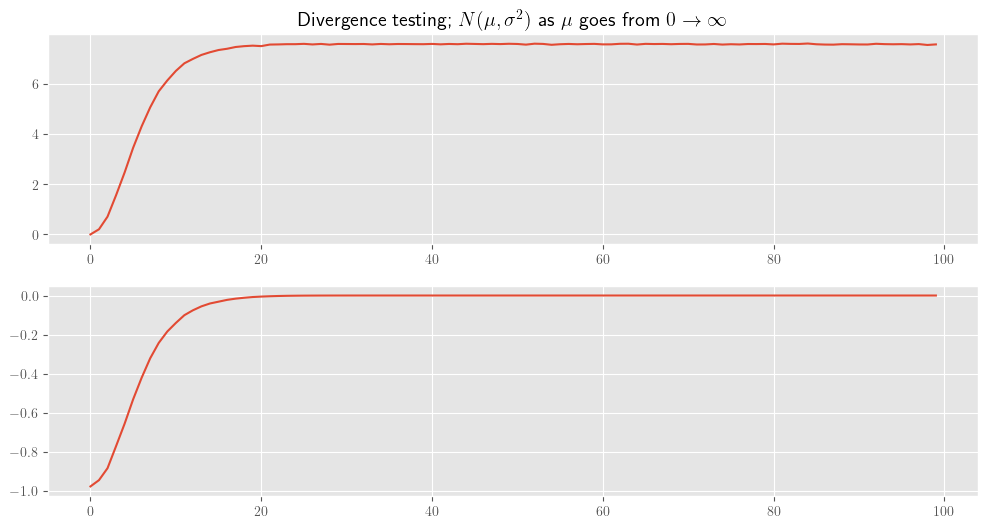

In [344]:
_, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].plot(mdd_scores)
axs[1].plot(-ker_scores)
axs[0].set_title(r"Divergence testing; $N(\mu, \sigma^2)$ as $\mu$ goes from $0 \rightarrow \infty$")

In [345]:
D = 768 # Embedding dim
N = 1   # Number of samples for prediction and ground truth; mimics embedding a string and returning (1, D)

mdd_scores = []
ker_scores = []
# Let's vary the mean first…
for sigma in range(100):
    x = torch.from_numpy(np.random.normal(0, sigma, size=(N, D)))
    y = torch.from_numpy(np.random.normal(0, 1, size=(N, D))) # standard normal
    trajectories = torch.from_numpy(np.random.normal(0, 1, size=(N*1000, D))).mean(0, keepdim=True) # Sample 1000 trajectories
    random       = torch.from_numpy(np.random.uniform(0, 100, (N*10, D))).mean(0, keepdim=True)     # Sample 10 random sequences

    rand_score_ker = rbf_kernel(y, random).mean()
    base_score_ker = rbf_kernel(y, trajectories).mean()
    rand_score_mdd = MMD(y.T, random.T)
    base_score_mdd = MMD(y.T, trajectories.T)

    pred_ker = rbf_kernel(y, x).mean()
    pred_ker = normalize_score(pred_ker, base_score_ker, rand_score_ker)
    pred_mdd = MMD(y.T, x.T)  

    mdd_scores.append(pred_mdd)
    ker_scores.append(pred_ker)

In [346]:
mdd_scores = np.array(mdd_scores)
ker_scores = np.array(ker_scores)

Text(0.5, 1.0, 'Divergence testing; $N(\\mu, \\sigma^2)$ as $\\sigma^2$ goes from $0 \\rightarrow \\infty$')

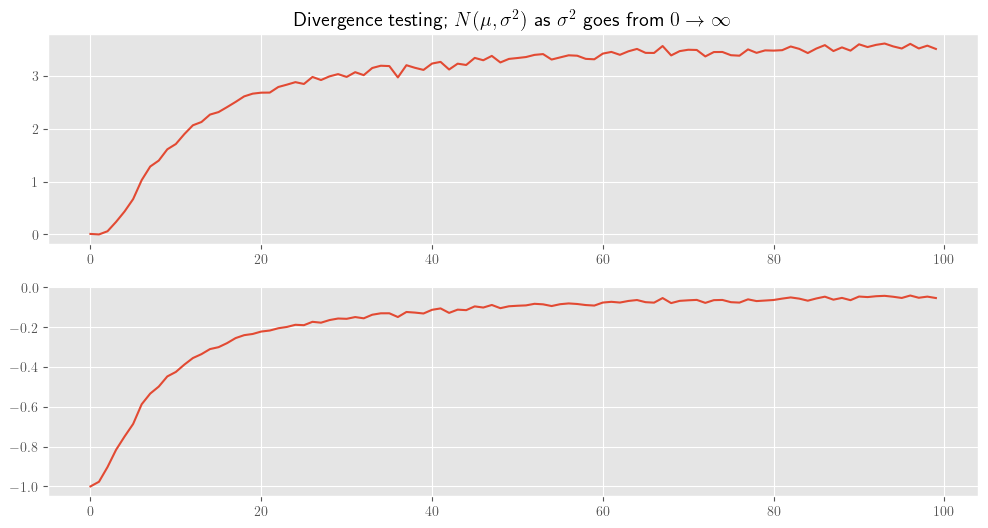

In [347]:
_, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].plot(mdd_scores)
axs[1].plot(-ker_scores)
axs[0].set_title(r"Divergence testing; $N(\mu, \sigma^2)$ as $\sigma^2$ goes from $0 \rightarrow \infty$")

QED.

In [356]:
D = 768 # Embedding dim
N = 1   # Number of samples for prediction and ground truth; mimics embedding a string and returning (1, D)

mdd_scores = []
ker_scores = []
# Let's vary the mean first…

for sigma in range(100):
    mu = np.random.uniform(0, 20)
    sigma = np.random.uniform(0, 20)
    
    x = torch.from_numpy(np.random.normal(mu, sigma, size=(N, D)))
    y = torch.from_numpy(np.random.normal(0, 1, size=(N, D))) # standard normal
    trajectories = torch.from_numpy(np.random.normal(0, 1, size=(N*10_000, D))).mean(0, keepdim=True) # Sample 1000 trajectories
    random       = torch.from_numpy(np.random.uniform(0, 100, (N*10, D))).mean(0, keepdim=True)     # Sample 10 random sequences

    rand_score_ker = rbf_kernel(y, random).mean()
    base_score_ker = rbf_kernel(y, trajectories).mean()
    rand_score_mdd = MMD(y.T, random.T)
    base_score_mdd = MMD(y.T, trajectories.T)

    pred_ker = rbf_kernel(y, x).mean()
    pred_ker = normalize_score(pred_ker, base_score_ker, rand_score_ker)
    pred_mdd = MMD(y.T, x.T)  

    mdd_scores.append(pred_mdd)
    ker_scores.append(pred_ker)

mdd_scores = np.array(mdd_scores)
ker_scores = np.array(ker_scores)

Text(0.5, 1.0, 'Divergence testing; $N(\\mu, \\sigma^2)$ as $\\sigma^2$ and $\\mu$ goes from $0 \\rightarrow \\infty$')

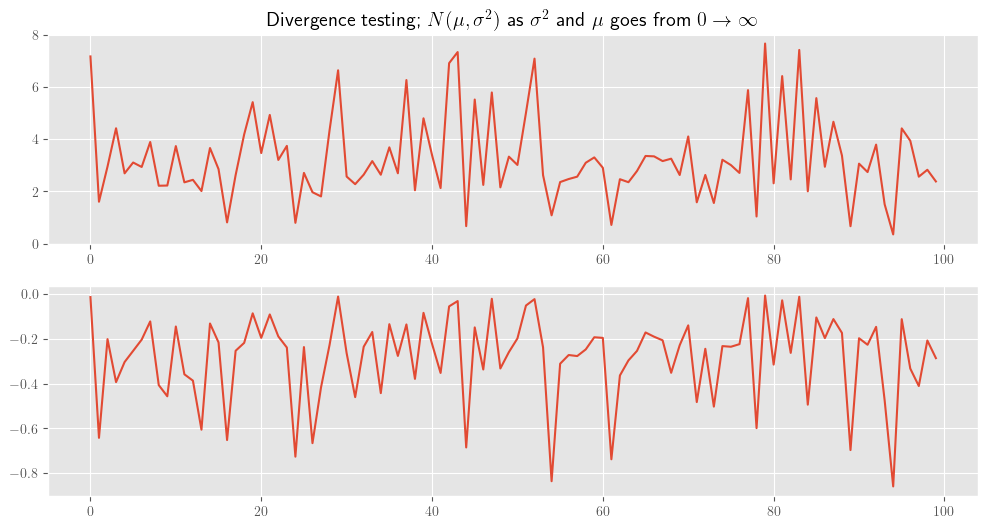

In [357]:
_, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].plot(mdd_scores)
axs[1].plot(-ker_scores)
axs[0].set_title(r"Divergence testing; $N(\mu, \sigma^2)$ as $\sigma^2$ and $\mu$ goes from $0 \rightarrow \infty$")

In [358]:
from scipy.stats import spearmanr, pearsonr

In [359]:
spearmanr(mdd_scores, -ker_scores)

SignificanceResult(statistic=0.9082148214821482, pvalue=7.459408634939086e-39)

In [360]:
pearsonr(mdd_scores, -ker_scores)

PearsonRResult(statistic=0.8239306043249568, pvalue=6.53452916810676e-26)